## Import Data


In [21]:
# --- Import Library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [22]:
# --- 1. Load Data ---
data = pd.read_csv("DukuhKupang.csv")
print("Data Awal:")
print(data.info())

# Drop kolom yang tidak diperlukan
drop_cols = [
    'Datetime','Timezone','AQI CN','AQI US',
    'HCHO (ppb)','TVOC (ppb)',
    'Temperature (Fahrenheit)','Temperature (Celsius)'
]
data = data.drop(columns=drop_cols)

Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40043 entries, 0 to 40042
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timezone                  40043 non-null  object 
 1   Datetime                  40043 non-null  object 
 2   AQI US                    40043 non-null  int64  
 3   AQI CN                    40043 non-null  int64  
 4   PM2.5 (ug/m3)             40043 non-null  float64
 5   PM10 (ug/m3)              40043 non-null  int64  
 6   CO2 (ppm)                 40043 non-null  int64  
 7   Temperature (Celsius)     40043 non-null  float64
 8   Temperature (Fahrenheit)  40043 non-null  float64
 9   Humidity (%)              40043 non-null  int64  
 10  HCHO (ppb)                0 non-null      float64
 11  TVOC (ppb)                0 non-null      float64
dtypes: float64(5), int64(5), object(2)
memory usage: 3.7+ MB
None


In [23]:
# --- 2. Cek Missing Values & Duplikat ---
print("Missing values:\n", data.isnull().sum())
print("Duplicated:", data.duplicated().sum())

# Hapus duplikat
data = data.drop_duplicates()


Missing values:
 PM2.5 (ug/m3)    0
PM10 (ug/m3)     0
CO2 (ppm)        0
Humidity (%)     0
dtype: int64
Duplicated: 1630


In [24]:
# --- 3. Deteksi & Hapus Outlier (IQR loop) ---
data_cleaned = data.copy()

while True:
    Q1 = data_cleaned.quantile(0.25)
    Q3 = data_cleaned.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_idx = data_cleaned[
        (data_cleaned < lower_bound) | (data_cleaned > upper_bound)
    ].dropna(how='all').index

    if len(outlier_idx) == 0:
        print("✅ No more outliers detected.")
        break
    else:
        print(f"⚠️ Removing {len(outlier_idx)} outliers...")
        data_cleaned = data_cleaned.drop(outlier_idx)

print(f"Jumlah data akhir: {len(data_cleaned)}")
display(data_cleaned.head())


⚠️ Removing 3980 outliers...
⚠️ Removing 2084 outliers...
⚠️ Removing 1136 outliers...
⚠️ Removing 471 outliers...
⚠️ Removing 148 outliers...
⚠️ Removing 129 outliers...
⚠️ Removing 89 outliers...
⚠️ Removing 281 outliers...
✅ No more outliers detected.
Jumlah data akhir: 30095


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Humidity (%)
0,21.0,35,430,47
1,17.0,37,430,46
2,19.0,32,428,46
3,18.0,31,428,47
4,19.0,40,427,47


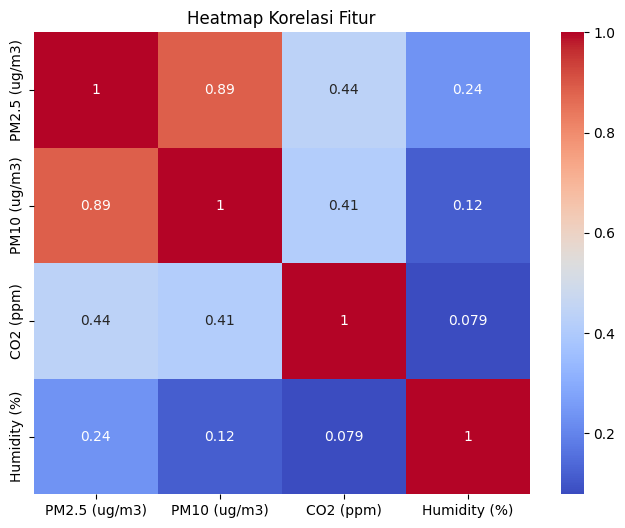

In [25]:
# --- 4. Visualisasi Korelasi ---
plt.figure(figsize=(8,6))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

# Prepocessing

In [27]:
# --- 5. Preprocessing Data ---
X = data_cleaned.copy()
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = range(3, 10)

best_config = None
best_score = -1  # untuk silhouette (lebih tinggi lebih baik)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_scaled)
        
        # Jika semua noise atau hanya 1 cluster, skip
        if len(set(labels)) <= 1 or len(set(labels)) == 2 and -1 in set(labels):
            continue
        
        try:
            sil_score = silhouette_score(X_train_scaled, labels)
            dbi_score = davies_bouldin_score(X_train_scaled, labels)
            
            print(f"eps={eps}, min_samples={min_samples} "
                  f"=> silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")
            
            # pilih berdasarkan silhouette
            if sil_score > best_score:
                best_score = sil_score
                best_config = (eps, min_samples, sil_score, dbi_score)
        
        except:
            continue

print("\n🔥 Best Config:")
print(f"eps={best_config[0]}, min_samples={best_config[1]}, "
      f"silhouette={best_config[2]:.3f}, DBI={best_config[3]:.3f}")


eps=0.2, min_samples=3 => silhouette=-0.610, DBI=1.366
eps=0.2, min_samples=4 => silhouette=-0.614, DBI=1.376
eps=0.2, min_samples=5 => silhouette=-0.617, DBI=1.437
eps=0.2, min_samples=6 => silhouette=-0.634, DBI=1.457
eps=0.2, min_samples=7 => silhouette=-0.633, DBI=1.618
eps=0.2, min_samples=8 => silhouette=-0.621, DBI=1.791
eps=0.2, min_samples=9 => silhouette=-0.625, DBI=2.001
eps=0.4, min_samples=3 => silhouette=-0.044, DBI=1.540
eps=0.4, min_samples=4 => silhouette=0.212, DBI=2.075
eps=0.4, min_samples=5 => silhouette=0.160, DBI=1.647
eps=0.4, min_samples=6 => silhouette=0.200, DBI=1.983
eps=0.4, min_samples=7 => silhouette=0.056, DBI=1.514
eps=0.4, min_samples=8 => silhouette=0.053, DBI=1.669
eps=0.4, min_samples=9 => silhouette=-0.009, DBI=1.965

🔥 Best Config:
eps=0.4, min_samples=4, silhouette=0.212, DBI=2.075


In [30]:
# --- 6. DBSCAN Clustering ---
dbscan = DBSCAN(eps=best_config[0], min_samples=best_config[1])
train_clusters = dbscan.fit_predict(X_train_scaled)

# Tambahkan hasil cluster ke X_train
X_train = X_train.copy()
X_train["Cluster"] = train_clusters

print(f"✅ Number of clusters: {len(set(train_clusters)) - (1 if -1 in train_clusters else 0)}")
print(f"⚠️ Noise points: {list(train_clusters).count(-1)}")

✅ Number of clusters: 2
⚠️ Noise points: 290


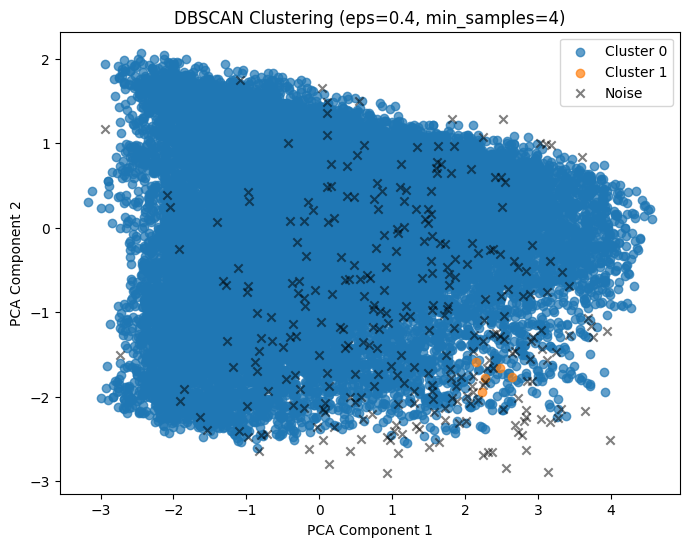

Silhouette Score: 0.212
Davies-Bouldin Index: 2.075


In [31]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
for label in set(train_clusters):
    if label == -1:
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            c="k", label="Noise", alpha=0.5, marker="x"
        )
    else:
        plt.scatter(
            X_reduced[train_clusters == label, 0],
            X_reduced[train_clusters == label, 1],
            label=f"Cluster {label}", alpha=0.7
        )

plt.title(f"DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# %%
# --- 8. Evaluasi Clustering ---
silhouette_avg = silhouette_score(X_train_scaled, train_clusters)
db_index = davies_bouldin_score(X_train_scaled, train_clusters)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")


AQI_Category   Good  Moderate  Satisfactory  Severe
Cluster                                            
-1               37       119           128       6
 0            12126      1327         10234      94
 1                0         5             0       0


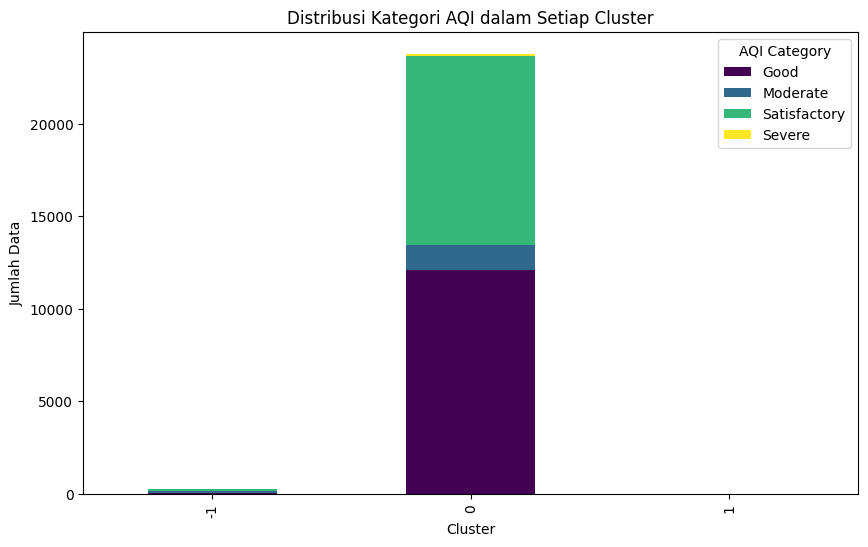

In [32]:
# --- 9. Hitung AQI (Linear Segmentation) ---

# Tabel breakpoints (Bmin, Bmax, Imin, Imax)
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)],
    
    # Contoh adaptasi CO2 (ppm)
    "CO2": [(0, 1000, 0, 50),
            (1001, 2000, 51, 100),
            (2001, 5000, 101, 200),
            (5001, 10000, 201, 300),
            (10001, 20000, 301, 400)]
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan

def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    sub_co2  = calculate_sub_index("CO2", row["CO2 (ppm)"])
    return max(sub_pm25, sub_pm10, sub_co2)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

# Tambahkan ke dataframe
X_train["AQI_Value"] = X_train.apply(calculate_aqi_linear, axis=1)
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)

# %%
# --- 10. Crosstab Cluster vs AQI Category ---
crosstab = pd.crosstab(X_train["Cluster"], X_train["AQI_Category"])
print(crosstab)

crosstab.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()